# **Austin Animal Shelter Capstone**
  As an avid animal lover and having volunteered in my local animal shelter, I wanted to analyze and visualize data obtained from other animal shelters. The Austin Animal Shelter publishes its data online through https://data.austintexas.gov/

  The primary mission of animal shelters, particularly as a no-kill center, is to maximize the positive outcomes by adopting out as many pets as possible to loving homes and to minimize costs associated with caring for stray animals over an extended period of time.

  This project is intended to visualize the performance of the Austin Animal Shelter, and guide recommendations regarding the allocation of advertising resources and veteranary resources to minimize loss of life and minimize time in shelter. 

  In addition, there has been anecdotal evidence that animal adoptions have increased dramatically with the onset of the COVID-19 lockdowns. I hypothesize that this should become apparent in visualizations generated from this dataset.

  Pet owners often have preferences for certain animal species . I hypothesize that there are statistically significant differences in the time prior to adoption depending on the species of animal.

#Installation and Importing of Required Modules

In [ ]:
# Package installation Cell
!pip install sodapy
!pip install researchpy

In [ ]:
# Module Import Cell
import numpy as np 
import pandas as pd 
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as rp
from scipy.stats import f_oneway
from scipy.stats import pearsonr
from sodapy import Socrata

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Acquisition and Processing of Shelter Data

In [ ]:
# Data Acquisiton Cell
# By using API provided by city of Austin, can obtain real time data directly from their database.

# Login credentials
client = Socrata("data.austintexas.gov",
                  "f1P6SIcQar0M9yL7rgt1UcpQ0",
                  username="donald.sun91@gmail.com",
                  password="Capstone3")

# Request for intake/outcome database information
# Limit hardcoded above 125000 to ensure complete download of dataset
# Intake Source = https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm
intake = client.get("wter-evkm", limit=225000)
# Outcome Source = https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238
outcome = client.get("9t4d-g238", limit=225000)

# Convert to pandas DataFrame
intake_df = pd.DataFrame.from_records(intake)
outcome_df = pd.DataFrame.from_records(outcome)

In [ ]:
# Quality check for data acquisition and information completeness
# Count of animal_id should be over 125000
# Non_null count of columns should match count of animal_id
intake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125117 entries, 0 to 125116
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   animal_id         125117 non-null  object
 1   name              85766 non-null   object
 2   datetime          125117 non-null  object
 3   datetime2         125117 non-null  object
 4   found_location    125117 non-null  object
 5   intake_type       125117 non-null  object
 6   intake_condition  125117 non-null  object
 7   animal_type       125117 non-null  object
 8   sex_upon_intake   125117 non-null  object
 9   age_upon_intake   125117 non-null  object
 10  breed             125117 non-null  object
 11  color             125117 non-null  object
dtypes: object(12)
memory usage: 11.5+ MB


Intake information shows 100% completness, not counting names. Not all animals given names

In [ ]:
# Quality check for data acquisition and information completeness
# Count of animal_id should be over 125000
# Non_null count of columns should match count of animal_id
outcome_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125445 entries, 0 to 125444
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   animal_id         125445 non-null  object
 1   name              86179 non-null   object
 2   datetime          125445 non-null  object
 3   monthyear         125445 non-null  object
 4   date_of_birth     125445 non-null  object
 5   outcome_type      125424 non-null  object
 6   animal_type       125445 non-null  object
 7   sex_upon_outcome  125445 non-null  object
 8   age_upon_outcome  125445 non-null  object
 9   breed             125445 non-null  object
 10  color             125445 non-null  object
 11  outcome_subtype   57842 non-null   object
dtypes: object(12)
memory usage: 11.5+ MB


Outcome information shows some null values in outcome_type, indicating that data was not fully populated by Animal Shelter. This represents a tiny portion of the overall data and can be excluded from analysis if necessary.

In [ ]:
# Removing duplicate animal_id's from dataframe
# Saved to new DF to preserve initial API request and minimize downloads
intake_df2 = intake_df.drop_duplicates(subset='animal_id',keep=False)
outcome_df2 = outcome_df.drop_duplicates(subset='animal_id',keep=False)
dropped_intake = len(intake_df)-len(intake_df2)
dropped_outcome = len(outcome_df)-len(outcome_df2)
repeat = (dropped_intake+dropped_outcome)/(len(intake_df)+len(outcome_df))

print(dropped_intake,' number of duplicate intake records have been removed.')
print(dropped_outcome,' number of duplicate outcome records have been removed.')
print(round(repeat,3)*100,'% of animals have entered the shelter multiple times')

23484  number of duplicate intake records have been removed.
23478  number of duplicate outcome records have been removed.
18.7 % of animals have entered the shelter multiple times


In [ ]:
# Checking the dataframe following removal of all duplicate records
intake_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101633 entries, 0 to 125116
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   animal_id         101633 non-null  object
 1   name              63059 non-null   object
 2   datetime          101633 non-null  object
 3   datetime2         101633 non-null  object
 4   found_location    101633 non-null  object
 5   intake_type       101633 non-null  object
 6   intake_condition  101633 non-null  object
 7   animal_type       101633 non-null  object
 8   sex_upon_intake   101633 non-null  object
 9   age_upon_intake   101633 non-null  object
 10  breed             101633 non-null  object
 11  color             101633 non-null  object
dtypes: object(12)
memory usage: 10.1+ MB


In [ ]:
# Checking the dataframe following removal of all duplicate records
outcome_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101967 entries, 0 to 125444
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   animal_id         101967 non-null  object
 1   name              63480 non-null   object
 2   datetime          101967 non-null  object
 3   monthyear         101967 non-null  object
 4   date_of_birth     101967 non-null  object
 5   outcome_type      101952 non-null  object
 6   animal_type       101967 non-null  object
 7   sex_upon_outcome  101967 non-null  object
 8   age_upon_outcome  101967 non-null  object
 9   breed             101967 non-null  object
 10  color             101967 non-null  object
 11  outcome_subtype   53183 non-null   object
dtypes: object(12)
memory usage: 10.1+ MB


Duplicate entries correspond to individual animals who for one reason or another, have been sent to the animal shelter multiple times. This complicates the joining of the intake and outcome dataframes, and represents a distinct population of animals with different characteristics than those who only enter the shelter once. Those characteristics may include psychological or physical issues, an animal who's owners allow it to roam freely, or simply an unlucky animal who has been surrendered by multiple unprepared owners. They will be excluded from the analysis.

In [ ]:
# Dropped duplicate and unused columns to reduce size of combined dataframe
outcome_df2 = outcome_df2.drop(columns=['datetime','name','date_of_birth'])
outcome_df2 = outcome_df2.rename(columns={'monthyear': 'outcome_date'})
outcome_df2 = outcome_df2.set_index('animal_id')
outcome_df2.head()

,outcome_date,outcome_type,animal_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype
animal_id,,,,,,,,
A832070,2021-04-14T17:28:00.000,Adoption,Dog,Spayed Female,8 months,Pit Bull Mix,Black/White,NaN
A831616,2021-04-14T17:13:00.000,Adoption,Dog,Spayed Female,2 years,Australian Kelpie Mix,Brown/Black,NaN
A831615,2021-04-14T17:12:00.000,Adoption,Dog,Spayed Female,2 years,Australian Kelpie Mix,Black/Brown,NaN
A832503,2021-04-14T16:58:00.000,Transfer,Cat,Intact Male,1 week,Domestic Shorthair,Blue,Partner
A832502,2021-04-14T16:58:00.000,Transfer,Cat,Intact Male,1 week,Domestic Shorthair,Blue,Partner


In [ ]:
# Dropped duplicate and unused columns to reduce size of combined dataframe
intake_df2 = intake_df2.drop(columns=['datetime2','found_location','breed','color','name'])
intake_df2 = intake_df2.rename(columns={'datetime': 'intake_date'})
intake_df2 = intake_df2.set_index('animal_id')
intake_df2.head()

,intake_date,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake
animal_id,,,,,,
A832522,2021-04-14T17:46:00.000,Owner Surrender,Normal,Dog,Intact Female,5 years
A832520,2021-04-14T17:31:00.000,Stray,Normal,Dog,Intact Female,2 months
A832519,2021-04-14T17:31:00.000,Stray,Normal,Dog,Intact Female,2 years
A832521,2021-04-14T17:31:00.000,Stray,Normal,Dog,Intact Female,2 months
A832518,2021-04-14T16:59:00.000,Stray,Normal,Dog,Intact Male,2 years


In [ ]:
# Joined outcome data onto intake data, some outcome data excluded as some outcomes dont have associated intake data
i_o = intake_df2.join(outcome_df2,how='inner', on='animal_id',lsuffix='_i',rsuffix='_o')

# Create new dataframe for analysis, dropping duplicate columns
i_o = i_o.drop(columns=['animal_type_o'])
i_o.head()

,intake_date,intake_type,intake_condition,animal_type_i,sex_upon_intake,age_upon_intake,outcome_date,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype
animal_id,,,,,,,,,,,,,
A832502,2021-04-14T14:37:00.000,Stray,Nursing,Cat,Intact Male,1 week,2021-04-14T16:58:00.000,Transfer,Intact Male,1 week,Domestic Shorthair,Blue,Partner
A832500,2021-04-14T14:37:00.000,Stray,Nursing,Cat,Intact Male,1 week,2021-04-14T16:58:00.000,Transfer,Intact Male,1 week,Domestic Shorthair,Brown Tabby,Partner
A832503,2021-04-14T14:37:00.000,Stray,Nursing,Cat,Intact Male,1 week,2021-04-14T16:58:00.000,Transfer,Intact Male,1 week,Domestic Shorthair,Blue,Partner
A832490,2021-04-14T13:40:00.000,Stray,Injured,Cat,Intact Male,1 weeks,2021-04-14T14:26:00.000,Euthanasia,Intact Male,NULL,Domestic Shorthair Mix,Blue Tabby,Suffering
A832474,2021-04-14T11:58:00.000,Wildlife,Sick,Other,Unknown,3 years,2021-04-14T12:01:00.000,Disposal,Unknown,3 years,Opossum,Gray/White,NaN


In [ ]:
# Expect to see fully populated data, excluding outcome_type
# Count of outcome_type nulls should be equal to original dataframe
i_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101067 entries, A832502 to A521520
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   intake_date       101067 non-null  object
 1   intake_type       101067 non-null  object
 2   intake_condition  101067 non-null  object
 3   animal_type_i     101067 non-null  object
 4   sex_upon_intake   101067 non-null  object
 5   age_upon_intake   101067 non-null  object
 6   outcome_date      101067 non-null  object
 7   outcome_type      101052 non-null  object
 8   sex_upon_outcome  101067 non-null  object
 9   age_upon_outcome  101067 non-null  object
 10  breed             101067 non-null  object
 11  color             101067 non-null  object
 12  outcome_subtype   52701 non-null   object
dtypes: object(13)
memory usage: 10.8+ MB


Successfully joined intake and outcome data. 

In [ ]:
# Calculating sheltertime for use in further calculations

# Converting date columns from objects into datetime64 dtype
i_o['intake_date'] = pd.to_datetime(i_o['intake_date'], format='%Y-%m-%d')
i_o['outcome_date'] = pd.to_datetime(i_o['outcome_date'],format='%Y-%m-%d')
# Calculating days in shelter and converting datatype from timedelta to int64
# Converting timedelta to int64 with .dt.days
intake = i_o['intake_date']
outcome = i_o['outcome_date']
i_o = i_o.assign(sheltertime = (outcome-intake).dt.days)
i_o.head()

,intake_date,intake_type,intake_condition,animal_type_i,sex_upon_intake,age_upon_intake,outcome_date,outcome_type,sex_upon_outcome,age_upon_outcome,breed,color,outcome_subtype,sheltertime
animal_id,,,,,,,,,,,,,,
A832502,2021-04-14 14:37:00,Stray,Nursing,Cat,Intact Male,1 week,2021-04-14 16:58:00,Transfer,Intact Male,1 week,Domestic Shorthair,Blue,Partner,0
A832500,2021-04-14 14:37:00,Stray,Nursing,Cat,Intact Male,1 week,2021-04-14 16:58:00,Transfer,Intact Male,1 week,Domestic Shorthair,Brown Tabby,Partner,0
A832503,2021-04-14 14:37:00,Stray,Nursing,Cat,Intact Male,1 week,2021-04-14 16:58:00,Transfer,Intact Male,1 week,Domestic Shorthair,Blue,Partner,0
A832490,2021-04-14 13:40:00,Stray,Injured,Cat,Intact Male,1 weeks,2021-04-14 14:26:00,Euthanasia,Intact Male,NULL,Domestic Shorthair Mix,Blue Tabby,Suffering,0
A832474,2021-04-14 11:58:00,Wildlife,Sick,Other,Unknown,3 years,2021-04-14 12:01:00,Disposal,Unknown,3 years,Opossum,Gray/White,NaN,0


#Animal Volume and Adoption Rates in Austin Animal Shelter

Media reports indicate that many pets were added to American households during the COVID-19 lockdowns. This trend should be reflected in the Austin Animal Shelters data.


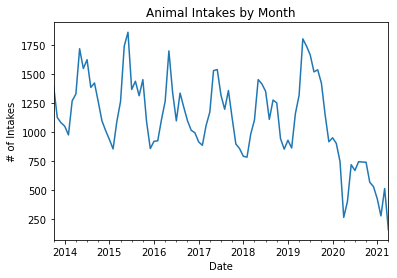

In [ ]:
# Line chart depicting animal intakes per month from 2014 to 2021
monthly_intakes = i_o.groupby(pd.Grouper(key='intake_date',freq='M'))['intake_date'].count()
monthly_intakes.plot.line(title='Animal Intakes by Month', xlabel='Date', ylabel='# of Intakes')

On this chart we can see that **animal intakes are cyclical** in nature and dramatically **rise during the spring and summer months**, as animals are actively breeding. With the onset of COVID-19 lockdowns and restrictions in the spring of 2020, intake volume decreased dramatically while still maintaining its cyclical nature.

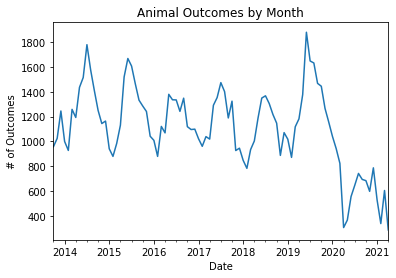

In [ ]:
# Line chart depicting animal outcomes per month from 2014 to 2021
monthly_outcomes = i_o.groupby(pd.Grouper(key='outcome_date',freq='M'))['intake_date'].count()
monthly_outcomes.plot.line(title='Animal Outcomes by Month', xlabel='Date', ylabel='# of Outcomes')

Outcomes track closely with the intake data.

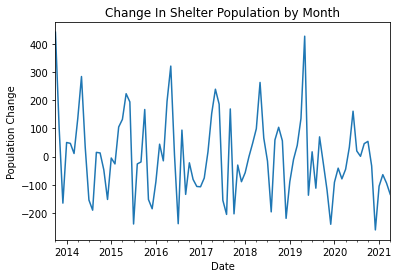

In [ ]:
m_outcomes = i_o.groupby(pd.Grouper(key='outcome_date',freq='M'))['intake_date'].count()
m_intakes = i_o.groupby(pd.Grouper(key='intake_date',freq='M'))['intake_date'].count()
m_population = m_intakes - m_outcomes
m_population.plot.line(title='Change In Shelter Population by Month', xlabel='Date', ylabel='Population Change')

Positive values indicate that the shelter is experiencing a net increase in population, while negative values indicate that the net population is decreasing. 

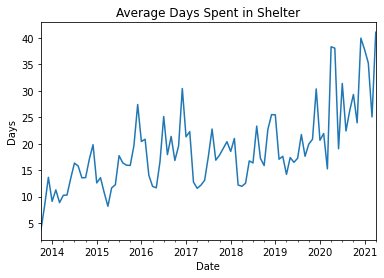

In [ ]:
# Line chart depicting average sheltertime of animals overtime
monthly_duration = (i_o.groupby(pd.Grouper(key='outcome_date',freq='M'))['sheltertime'].sum())/(i_o.groupby(pd.Grouper(key='outcome_date',freq='M'))['sheltertime'].count())
monthly_duration.plot(kind='line',title='Average Days Spent in Shelter', xlabel='Date', ylabel='Days')

By plotting the average sheltertime of animals, we can see that while **the shelter handled significantly fewer animals** relative to other years, during the COVID-19 pandemic, the **average adoption times trended upwards** despite the reduced utilization. This is due in part to the restriction of public visitors to appointment only. 

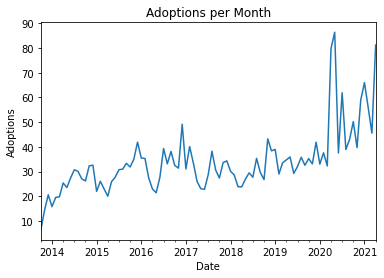

In [ ]:
# Filtered Outcomes to only Adoptions or Return To Owner - Adopt
adoption_df = i_o[(i_o['outcome_type']=='Adoption')|(i_o['outcome_type']=='Rto-Adopt')]
monthly_adoptions = (adoption_df.groupby(pd.Grouper(key='outcome_date',freq='M'))['sheltertime'].sum())/(adoption_df.groupby(pd.Grouper(key='outcome_date',freq='M'))['sheltertime'].count())
monthly_adoptions.plot(kind='line',title='Adoptions per Month', xlabel='Date', ylabel='Adoptions')

Taken all together, **the data indicates that there was a surge in adoptions from the Austin Animal Shelter, proving our hypothesis to be true**. This was despite a dramatic decrease in the overall intakes and outcomes, indicating that as a proportion of outcomes, adoptions made up a greater share than previous years. As shown in the above chart, adoptions in previous years were typically anywhere from 20 to 50 adoptions per month, while during the COVID-19 lockdowns pet adoptions were up to a minimum of about 40 and a maximum of 90, or about double from previous years.

Animal welfare advocates worry that with this surge of adoptions, pet surrenders will trend up following the end of lockdowns. This is due to people spending more time outside and at work, and having less time and resources to take care of their newly adopted pets. 

In [ ]:
# Converting original dataframe data types from object to date
# Dataframes used when joined dataframe not necessary
intake_df['datetime'] = pd.to_datetime(intake_df['datetime'], format='%Y-%m-%d')
outcome_df['datetime'] = pd.to_datetime(outcome_df['datetime'],format='%Y-%m-%d')

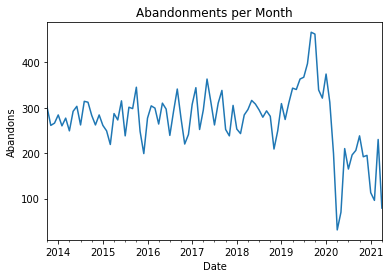

In [ ]:
# Filtered outcomes to surrenders

surrender_df = intake_df[(intake_df['intake_type']=='Owner Surrender')]
monthly_abandon = (surrender_df.groupby(pd.Grouper(key='datetime',freq='M'))['intake_type'].count())
monthly_abandon.plot.line(title='Abandonments per Month', xlabel='Date', ylabel='Abandons')

As we can see, **pet abandonment to animal shelters is down during the 2020-2021 period**. Using this notebook to reobtain data in the future, we expect to see the monthly abandonment count to increase dramatically, assuming that the concerns of animal welfare advocates are well founded.

Sometimes animal shelters are unable to help its charges, and the animals end up dying in the shelter system. While it is unavoidable at times, it is still in the best interest of the shelter to monitor and minimize loss of life.

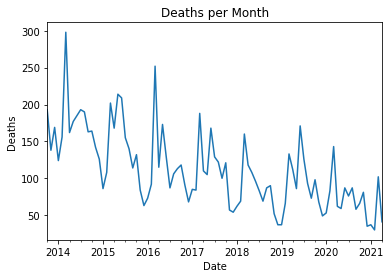

In [ ]:
# Filtered outcomes to death, disposal, or euthanasia

death_df = outcome_df[(outcome_df['outcome_type']=='Euthanasia')|(outcome_df['outcome_type']=='Died')|(outcome_df['outcome_type']=='Disposal')]
monthly_death = (death_df.groupby(pd.Grouper(key='datetime',freq='M'))['outcome_type'].count())
monthly_death.plot.line(title='Deaths per Month', xlabel='Date', ylabel='Deaths')

As we can see, **deaths have been trending downwards**, indicating that the shelter has been improving its performance year over year. However as the volume of animals handled in 2020-2021 was lower than previous years, it is unclear if this trend has continued.

#Rabies Risk in Austin, TX

Rabies is an infectious disease transferred via the saliva of mammals, typically wild mammals including bats, raccoons, skunks, and foxes.

There is currently no known treatment for rabies in pets, and **should a pet become infected with rabies its only possible outcome is euthanasia**. As such, animal shelters and animal control organizations are very concerned with keeping rabies risk to a minimum.

The following section is intended to visualize the rabies infection rate in order to determine if the risk of rabies is rising, static, or decreasing.

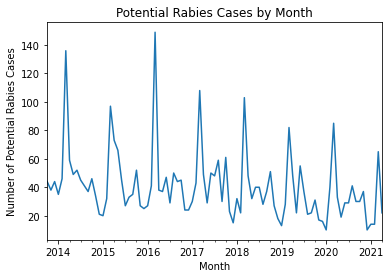

In [ ]:
# Line chart depicting number of animals euthanized due to rabies risk per month
# Create new filtered dataframe including only animals labeled as rabies risk
rabies_df = i_o[i_o['outcome_subtype'] == 'Rabies Risk']
monthly_rabies = rabies_df.groupby(pd.Grouper(key='outcome_date',freq='M'))['outcome_date'].count().plot.line(title='Potential Rabies Cases by Month', xlabel='Month',ylabel='Number of Potential Rabies Cases')

While the monthly intake/outcome graphs show dramatically reduced volume during the COVID-19 pandemic, the number of potentially rabies infected animals does not change as sharply. Overall it appears **Austin is reducing the frequency of rabies over time**.

# Factors Influencing Amount of Time Prior to Adoption



In [ ]:
# Dataframes containing only adopted animals, broken down by animal species.
cat_df = i_o[(i_o['animal_type_i']=='Cat')&((i_o['outcome_type']=='Adoption')|(i_o['outcome_type']=='Rto-Adopt'))]
dog_df = i_o[(i_o['animal_type_i']=='Dog')&((i_o['outcome_type']=='Adoption')|(i_o['outcome_type']=='Rto-Adopt'))]
bird_df = i_o[(i_o['animal_type_i']=='Bird')&((i_o['outcome_type']=='Adoption')|(i_o['outcome_type']=='Rto-Adopt'))]
other_df = i_o[(i_o['animal_type_i']=='Other')&((i_o['outcome_type']=='Adoption')|(i_o['outcome_type']=='Rto-Adopt'))]

In [ ]:
# Summary statistics of sheltertime grouped by animal type
rp.summary_cont(adoption_df['sheltertime'].groupby(adoption_df['animal_type_i']))

,N,Mean,SD,SE,95% Conf.,Interval
animal_type_i,,,,,,
Bird,206,13.4709,18.5348,1.2914,10.9248,16.0170
Cat,18623,41.1491,54.6901,0.4008,40.3635,41.9346
Dog,23632,26.4355,59.9366,0.3899,25.6713,27.1997
Livestock,8,168.7500,131.0003,46.3156,59.2310,278.2690
Other,493,24.6897,30.4058,1.3694,21.9990,27.3803


Quick descriptive statistics showing the time in shelter data, broken down by animal types.

In [ ]:
# One way ANOVA test of shelter time vs animal type
scipy.stats.f_oneway(i_o['sheltertime'][i_o['animal_type_i']== 'Cat'],
               i_o['sheltertime'][i_o['animal_type_i'] == 'Dog'],
               i_o['sheltertime'][i_o['animal_type_i'] == 'Bird'])

F_onewayResult(statistic=203.5660924553353, pvalue=6.060425837960418e-89)

In [ ]:
# One way ANOVA test of shelter time vs animal type
scipy.stats.f_oneway(cat_df['sheltertime'],dog_df['sheltertime'],bird_df['sheltertime'])

F_onewayResult(statistic=352.00644912127007, pvalue=2.3940812239670796e-152)

One way ANOVA test to determine if there is a statistically significant difference between the means of 3 or more groups. If the F value and P value are lower than the critical F value and alpha values respectively, we can conclude that there is a statistically significant difference between the groups.

In [ ]:
# Calculation of F-Critical Value

# Significance Level Used, input as % confidence.
qf = 0.95

# The numerator degrees of freedom are equal to the number of groups minus one
dfn = 2

# Degrees of Freedom, Denominator
# The denominator degrees of freedom are number of groups × (number of subjects minus one)
dfd = dfn*(cat_df['sheltertime'].count()+dog_df['sheltertime'].count()+bird_df['sheltertime'].count()-1)

# F Critical Value
f_crit = scipy.stats.f.ppf(qf,dfn,dfd)

print('The F-Critical Value is:',f_crit)

The F-Critical Value is:  2.9958379567715663


As the F statistic value is greater than the F critical value, and the p value is lower than the alpha, we can reject the null hypothesis and conclude that there is a statistically significant difference in shelter time between different animal species. This does not demonstrate a statistically significant difference between two specific animal groups however.

In [ ]:
# T Critical Value Calculation

# Significance Level Used, input as % confidence
qt = 0.95

# Degrees of freedom
catdog = cat_df['sheltertime'].count()+dog_df['sheltertime'].count()
catbird = cat_df['sheltertime'].count()+bird_df['sheltertime'].count()
dogbird = dog_df['sheltertime'].count()+bird_df['sheltertime'].count()

# T critical calculations for each pair of animal species involved in earlier ANOVA test
t_crit_catdog = scipy.stats.t.ppf(qt, catdog)
t_crit_catbird = scipy.stats.t.ppf(qt, catbird)
t_crit_dogbird = scipy.stats.t.ppf(qt, dogbird)

print('The T-Critical value for cats vs dogs is :', t_crit_catdog)
print('The T-Critical value for cats vs birds is :', t_crit_catbird)
print('The T-Critical value for birds vs dogs is :', t_crit_dogbird)

The T-Critical value for cats vs dogs is : 1.644889689021249
The T-Critical value for cats vs birds is : 1.6449345576741186
The T-Critical value for birds vs dogs is : 1.6449175513044623


In [ ]:
# Two Sample T-Tests - Cat vs Dog
scipy.stats.ttest_ind(cat_df['sheltertime'],dog_df['sheltertime'])

Ttest_indResult(statistic=26.031881077310402, pvalue=3.199297270794535e-148)

The T statistic exceeds the T critical value, and the p value is less than the alpha. We reject the null hypothesis and conclude that there is a statistically significant difference between the shelter time of cats and dogs.

In [ ]:
# Two Sample T-Tests - Cat vs Bird
scipy.stats.ttest_ind(cat_df['sheltertime'],bird_df['sheltertime'])

Ttest_indResult(statistic=7.258998355792272, pvalue=4.051467372913072e-13)

The T statistic exceeds the T critical value, and the p value is less than the alpha. We reject the null hypothesis and conclude that there is a statistically significant difference between the shelter time of cats and birds.

In [ ]:
# Two Sample T-Tests - Dog vs Bird
scipy.stats.ttest_ind(dog_df['sheltertime'],bird_df['sheltertime'])

Ttest_indResult(statistic=3.1032105591978043, pvalue=0.00191657269348141)

The T statistic exceeds the T critical value, and the p value is less than the alpha. We reject the null hypothesis and conclude that there is a statistically significant difference between the shelter time of dogs and birds.

Having completed the ANOVA tests and follow up T tests, we have determined that the descriptive statistics calculated at the start of this section are statistically significant. **This proves our hypothesis true that animal species has a statistically signnificant effect on adoption times**. From that information we can conclude that Birds are typically adopted out extremely quickly **(bird mean adoption time = 13.5 days)** and do not need significant resources to find them homes. Meanwhile dogs **(mean adoption time = 26.4 days)** take significantly longer, and cats even more time **(cat mean adoption time = 41.1 days)**. Advertising resources should therefore be focused on the cat population, and to a lesser extent dogs.

#Export Dataframe as .csv to Google Drive

In [ ]:
# Code block to export processed dataframe into csv file for use in other software/troubleshooting
from google.colab import drive
drive.mount('drive')

i_o.to_csv('join_data.csv')
!cp join_data.csv "drive/My Drive/"

intake_df2.to_csv('intake.csv')
!cp intake.csv "drive/My Drive/"

outcome_df2.to_csv('outcome.csv')
!cp outcome.csv "drive/My Drive/"

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
